In [60]:
%matplotlib inline
import pandas as pd
import string
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import joblib

from scipy.spatial.distance import cdist 

from collections import Counter

from wordcloud import WordCloud

import nltk as nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import *
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer


import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora, models

import sys
#from stop_words import get_stop_words

import csv
import _pickle as cPickle
from string import digits
import bz2
import pyLDAvis
import pyLDAvis.gensim_models

In [72]:
def load_dataframe(filename):
    return pd.read_csv(filename)

def tokenizeTweets(sentance):
    words = word_tokenize(sentance)
    noise_free_words = [word for word in words if word not in Stop_words]
    return noise_free_words


def cleanPunctuation(sentance):
    new_sentance = sentance.translate(str.maketrans('', '', string.punctuation))
    new_sentance = new_sentance.replace("“","").replace("’","").replace("”","")
    return new_sentance

def cleanLinks(sentance):
    sentance = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', sentance, flags=re.MULTILINE)
    return(sentance)

def stemming(wordsList):
    #getting the root of every word for all tweets
    rootList = []
    ps = PorterStemmer()
    for w in wordsList:
        #remove the 'Retweet' tag
        if (w != 'RT'):
            rootList.append(ps.stem(w))
    return rootList


def lemmataizeSentance(wordsList):
    #getting the root of every word for all tweets
    rootList = []
    wl = WordNetLemmatizer()
    for w in wordsList:
        #remove the 'Retweet' tag
        if (w != 'RT'):
            rootList.append(wl.lemmatize(w))
    return rootList


def chunking(wordsList):
    PartsOfSpeech = pos_tag(wordsList)
    Named_entities = ne_chunk(PartsOfSpeech)
    return Named_entities

def replace_empty_to_nan(sentance, dfm , index):
    if len(sentance) == 0 :
        dfm['text'][index] = float('NaN')        
    return dfm    


def remove_nan_rows(df):
    nan_value = float("NaN")
    df.replace("", nan_value, inplace=True)
    df.dropna(subset = ["text"], inplace=True)
    return df

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


def remove_unnecessary_data(dataframe):
    dfm = df_lemmatize = df_stem = df_chunk = dataframe.copy()
    
    #remove duplicate rows
    dfm = dfm.drop_duplicates(keep='first').copy() 
    
    #removing links,emoji's, punc and tokenzing the words and making 3 dfs in 3 methods
    for i in range(0, len(df.index)):
        temp = df['text'][i].lower()
        temp = remove_emoji(temp)
        temp = cleanLinks(temp)
        temp = cleanPunctuation(temp)
        temp = tokenizeTweets(temp)
        df_stem['text'][i] = stemming(temp)
        df_lemmatize['text'][i] = lemmataizeSentance(temp)
       
        df_stem = replace_empty_to_nan(temp ,df_stem, i)
        df_lemmatize = replace_empty_to_nan(temp ,df_lemmatize, i)
    
    df_stem =  remove_nan_rows(df_stem)    
    df_lemmatize =  remove_nan_rows(df_lemmatize)    
    
             
    return df_stem , df_lemmatize
    
    
#run phase 3 - Data Handling phase 

Stop_words = set (stopwords.words('English'))
df = load_dataframe('trumpTweets.csv')
results = remove_unnecessary_data(df)
df_lemmatize = results[1]
df_stem = results[0]
df_lemmatize.to_csv("df_lemmatize_token.csv")
df_stem.to_csv("df_stem_token.csv")

C:\Users\ronhu\AppData\Local\Temp\ipykernel_36816\742834939.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stem['text'][i] = stemming(temp)
C:\Users\ronhu\AppData\Local\Temp\ipykernel_36816\742834939.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lemmatize['text'][i] = lemmataizeSentance(temp)
C:\Users\ronhu\AppData\Local\Temp\ipykernel_36816\742834939.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['text'][i

## No need to run phase 3, its saved in the csv's files

df_lemmatize dataframe saved in "df_lemmatize_token.csv".

df_stem dataframe saved in "df_stem_token.csv".

In [40]:
# df_lemmatize = pd.read_csv("df_lemmatize_token.csv")
# df_stem = pd.read_csv("df_stem_token.csv")

In [73]:
#Training the model & Generating the clusters - 5 Clusters
def create_clusters(df,number_of_clusters, colors ,title):
    LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
    all_content_train = []
    j=0
    for em in df['text'].values:
        all_content_train.append(LabeledSentence1(em,[j]))
        j+=1
    
    print('Number of texts processed:' , j)    
    print('this graph is from: ' , title)    


    d2v_model = Doc2Vec(all_content_train,
                        window = 10,
                        min_count = 500, 
                        workers=7,
                        dm = 1,alpha=0.025,
                        min_alpha=0.001)

    d2v_model.train(all_content_train,
                    total_examples=d2v_model.corpus_count,
                    epochs=10,
                    start_alpha=0.002,
                    end_alpha=-0.016)

    #create Clusters
    kmeans_model = KMeans(n_clusters = number_of_clusters,
                          init='k-means++', 
                          max_iter=100) 
    
    
    X = kmeans_model.fit(d2v_model.dv.vectors)
    labels=kmeans_model.labels_.tolist()
    
    l = kmeans_model.fit_predict(d2v_model.dv.vectors)
    
    #Pca - minimize the number of dimensions for visualization
    pca = PCA(n_components=2).fit(d2v_model.dv.vectors)
    datapoint = pca.transform(d2v_model.dv.vectors)
    plt.figure
    
    #print clusters
    color = [colors[i] for i in labels]
    plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
    centroids = kmeans_model.cluster_centers_
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
    plt.show()
    return kmeans_model

In [74]:
#Creating the colored clusters
four_colors = ['#FFFF00', '#008000', '#0000FF', '#800080']
five_colors = ['#FFFF00', '#008000', '#0000FF', '#800080','#00FFFF']
six_colors = ['#FFFF00', '#008000', '#0000FF', '#800080','#00FFFF','#FF7F50']
ten_colors = ['#FFFF00', '#008000', '#0000FF', '#800080','#00FFFF','#FF7F50','#FF69B4','#4B0082','#ADD8E6','#FF4500']

Number of texts processed: 55253
this graph is from:  df_stem


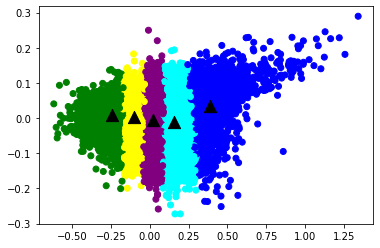

Number of texts processed: 55253
this graph is from:  df_lemmatize


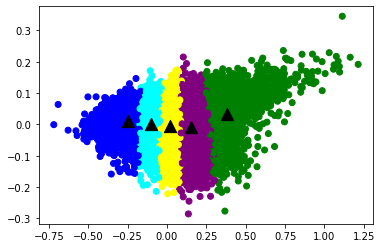

In [75]:
#Created a cluster of doc2vec & kmeans - 5 clusters
df_stem_five_cluster = create_clusters(df_stem,5,five_colors, 'df_stem')
df_lem_five_cluster = create_clusters(df_lemmatize,5,five_colors, 'df_lemmatize')

In [76]:
#Created a cluster of doc2vec & kmeans - 10 clusters
df_stem_ten_cluster = create_clusters(df_stem,10,ten_colors)
df_lem_ten_cluster = create_clusters(df_lemmatize,10,ten_colors)

TypeError: create_clusters() missing 1 required positional argument: 'title'

In [ ]:
#Creating LDA clusters of the tweets - 7 topics
let_dictionary = corpora.Dictionary(df_lemmatize['text'])
let_corpus = [dictionary.doc2bow(text) for text in df_lemmatize['text']]
let_lda = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=dictionary, num_topics=7, chunksize=1000, passes=20, workers=30)

In [ ]:
#Printing the clusters with lda_vis
let_lda_vis = pyLDAvis.gensim_models.prepare(let_lda, let_corpus, let_dictionary)
pyLDAvis.display(let_lda_vis)


In [ ]:
#Creating LDA clusters of the tweets - 7 topics
st_dictionary = corpora.Dictionary(df_stem['text'])
st_corpus = [dictionary.doc2bow(text) for text in df_stem['text']]
st_lda = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=dictionary, num_topics=7, chunksize=1000, passes=20, workers=30)

In [ ]:
#Printing the clusters with lda_vis
st_lda_vis = pyLDAvis.gensim_models.prepare(st_lda, st_corpus, st_dictionary)
pyLDAvis.display(st_lda_vis)
